In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType

from torch.nn import Transformer
from torch.nn import Transformer_1dcnn





from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
mm_scaler = MinMaxScaler()

class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)
        
        self.soc = df.iloc[x_size:, 20:21].values #SoC
        self.soc = self.soc.squeeze()
        self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
        self.soc = self.soc.squeeze()

        self.src_v = df.iloc[x_size:, 7:8].values #V
        self.src_v = self.src_v.squeeze()
        self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
        self.src_v = self.src_v.squeeze()

        self.src_c = df.iloc[x_size:, 6:7].values #I
        self.src_c = self.src_c.squeeze()
        self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
        self.src_c = self.src_c.squeeze()


        self.length = len(df) - x_size

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src_v = np.zeros([enc_seq_len, num_samples])
        src_c = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])

        
        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src_v[:,i] = self.src_v[start_x:end_x]
            src_c[:,i] = self.src_c[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.soc[start_y:end_y]

        src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
        src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))

        print(src_v.shape)
        self.src_v = src_v
        print(src_c.shape)
        self.src_c = src_c
        self.trg = trg

        self.len = len(src_v)

    def __getitem__(self, i):
        return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
    def __len__(self):
        return self.len

In [3]:
train_dataset_1 = StrideDataset("DST_80.csv", 50, 20, 1919, stride=5)

(2114, 50, 1)
(2114, 50, 1)


In [4]:
flag = np.zeros(19)
flag_soc = flag + 0.5
flag

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [5]:
class StrideDataset_e(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)
        
        self.soc = df.iloc[x_size:, 20:21].values #SoC
        self.soc = self.soc.squeeze()
        self.soc = mm_scaler.fit_transform(self.soc.reshape(-1, 1))
        self.soc = self.soc.squeeze()
        self.soc = np.concatenate((flag_soc, self.soc))
        plt.plot(self.soc)

        self.src_v = df.iloc[x_size:, 7:8].values #V
        self.src_v = self.src_v.squeeze()
        self.src_v = mm_scaler.fit_transform(self.src_v.reshape(-1, 1))
        self.src_v = self.src_v.squeeze()
        self.src_v = np.concatenate((self.src_v, flag))
        

        self.src_c = df.iloc[x_size:, 6:7].values #I
        self.src_c = self.src_c.squeeze()
        self.src_c = mm_scaler.fit_transform(self.src_c.reshape(-1, 1))
        self.src_c = self.src_c.squeeze()
        self.src_c = np.concatenate((self.src_c, flag))


        self.length = len(df) - x_size + 19

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src_v = np.zeros([enc_seq_len, num_samples])
        src_c = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])


        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src_v[:,i] = self.src_v[start_x:end_x]
            src_c[:,i] = self.src_c[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.soc[start_y:end_y]
            break
        print(start_x)
        print(end_x)
        
        print(start_y)
        print(end_y)

        src_v = src_v.reshape(src_v.shape[0], src_v.shape[1], 1).transpose((1,0,2))
        src_c = src_c.reshape(src_c.shape[0], src_c.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))
        print(src_v.shape)
        
        # trg = np.concatenate((flag,trg), 1)
        # print(trg.shape)

        self.src_v = src_v
        self.src_c = src_c
        self.trg = trg
        
        

        self.len = len(src_v)

    def __getitem__(self, i):
        return self.src_v[i], self.src_c[i], self.trg[i, :-1], self.trg[i, 1:]
    
    def __len__(self):
        return self.len

In [6]:
li = list([1,2,3,4,5,6])

print(li[:-1])
print(li[1:])
print(li[0:5])


[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[1, 2, 3, 4, 5]


0
50
50
70
(2209, 50, 1)


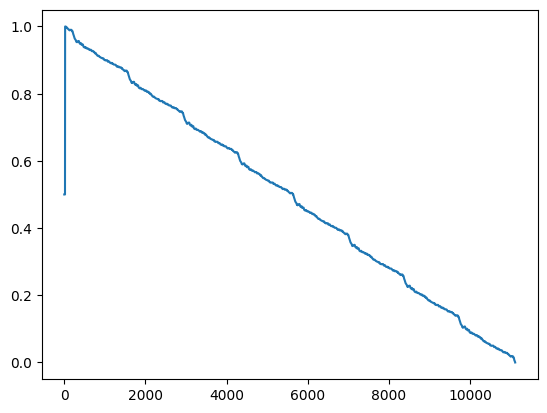

In [7]:
train_dataset_1 = StrideDataset_e("FUDS_80.csv", 50, 20, 2586, stride=5)


In [8]:
# class StrideDataset_2(Dataset):
#     def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
#         df = pd.read_csv(file_path)
        
#         self.data = df.iloc[x_size:, 13:14].values #SoC
#         self.data = self.data.squeeze()

#         self.length = len(df) - x_size

#         num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
#         src = np.zeros([enc_seq_len, num_samples])
#         trg = np.zeros([target_seq_len, num_samples])


#         for i in np.arange(num_samples):
#             start_x = stride*i
#             end_x = start_x + enc_seq_len
#             src[:,i] = self.data[start_x:end_x]

#             start_y = stride*i + enc_seq_len
#             end_y = start_y + target_seq_len
#             trg[:,i] = self.data[start_y:end_y]

#         src = src.reshape(src.shape[0], src.shape[1], 1).transpose((1,0,2))
#         trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))
#         self.src = src
#         self.trg = trg

#         self.len = len(src)

#     def __getitem__(self, i):
#         return self.src[i], self.trg[i, :-1], self.trg[i, 1:]
    
#     def __len__(self):
#         return self.len

In [9]:
flag_y = np.zeros(51)

In [10]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)
        #print(df.isnull().sum())

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[x_size:, 20:21].values
        
        self.length = len(df) - x_size

    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [11]:
dataset_d = CustomDataset("DST_80.csv", 1919)


In [12]:
train_dataset_1 = StrideDataset("DST_80.csv", 50, 20, 1919, stride=5)
train_dataset_2 = StrideDataset("US06_80.csv", 50, 20, 1207, stride=5)
# train_dataset_1 = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=5)
# train_dataset_2 = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=5)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])
# train_dataset = train_dataset_2


train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last=False)
# dataset_d = CustomDataset("DST_80.csv", 1919)

(2114, 50, 1)
(2114, 50, 1)
(2125, 50, 1)
(2125, 50, 1)


In [13]:
# plt.plot(train_dataset_1)
# plt.show()
# plt.plot(train_dataset.src_v.squeeze())
# plt.show()
# plt.plot(train_dataset.trg.squeeze())
# plt.show()


In [14]:
class TFModel(nn.Module):
    def __init__(self, d_model, nhead, nhid, nlayers, dropout=0.5):
        super(TFModel, self).__init__()

        # self.transformer = Transformer(d_model=d_model, nhead=nhead, dim_feedforward=nhid, num_encoder_layers=nlayers, num_decoder_layers=nlayers,dropout=dropout)
        
        # self.linear = nn.Linear(d_model, 1)
        # self.pos_encoder = PositionalEncoding(d_model, dropout)

        # self.encoder = nn.Linear(1, d_model)

        self.coder_in = nn.Linear(1,d_model)
        
        self.conv_in = nn.Sequential(
            nn.Conv1d(1, 500, kernel_size=15),
            nn.Softmax(dim=1),
            nn.Linear(50-15+1, 50) #src-ker+1, src
        )
        
        self.conv_in_dec = nn.Sequential(
            nn.Conv1d(1,500,kernel_size=15),
            nn.Softmax(dim=1),
            nn.Linear(20-15, 20-1) #dec-ker, dec-1
        )
        
        
        self.conv_out = nn.Sequential(
            nn.Conv1d(500,50,kernel_size=5,stride=3),
            #nn.ReLU(),
            nn.Conv1d(50,1,kernel_size=3,stride=1),
            #nn.ReLU(),
            nn.Linear(3,30),
            #nn.ReLU(),
            nn.Linear(30,19)
        )

        self.coder_pos = PositionalEncoding(d_model, dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)
        
        #
        self.encoder_layer_1dcnn = nn.TransformerEncoderLayer_1dcnn(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder_1dcnn = nn.TransformerEncoder_1dcnn(self.encoder_layer_1dcnn, num_layers=nlayers)
        #


        self.con_lin = nn.Linear(d_model*2, d_model)

        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=nlayers) #(target, memory) // memort->인코더에서 나온 컨텍스트벡터?
        #
        self.decoder_layer_1dcnn = nn.TransformerDecoderLayer_1dcnn(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_decoder_1dcnn = nn.TransformerDecoder_1dcnn(self.decoder_layer_1dcnn, num_layers=nlayers)
        #
        
        
        
        
        self.linear = nn.Sequential(
            nn.Linear(d_model, 1)
        )
        self.linear_in = nn.Linear(1, d_model)
        
        self.new = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model,d_model)
        )
        

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    #def forward(self, src, tgt, srcmask, tgtmask):
    def forward(self, src_v, src_c, tgt_s, src_mask_v, src_mask_c, tgtmask):
        # src_v = self.coder_in(src_v)
        src_v = self.conv_in(src_v.transpose(2,1)).transpose(2,1)
        src_v = self.coder_pos(src_v)

        src_c = self.coder_in(src_c)
        # src_c = self.conv_in(src_c.transpose(2,1)).transpose(2,1)
        src_c = self.coder_pos(src_c)
        # print(src_c.shape)
        
        
        con_v = src_v
        # con_c = src_c

        # con_v = self.transformer_encoder(src_v.transpose(0,1), src_mask_v).transpose(0,1)  #-> 그냥
        # con_v = self.transformer_encoder_1dcnn(src_v.transpose(0,1), src_mask_v) #-> 인코더 ff 1dcnn
        
        
        # # print(con_v.shape)
        con_c = self.transformer_encoder(src_c.transpose(0,1), src_mask_c).transpose(0,1)
        # con_c = self.transformer_encoder_1dcnn(src_c.transpose(0,1), src_mask_c)
        
        # con_c = self.new(con_c)
        
        
        
        
        
        
        #print(con_v.shape)
        #print(con_c.shape)
        

        con = torch.cat((con_v, con_c), dim=2)
        flag = con
        #print(con.shape)
        
        con = self.con_lin(con)
        #print(con.shape)
        
        
        #print(tgt_s.shape)
        tgt_s = self.coder_in(tgt_s)
        # tgt_s = self.conv_in_dec(tgt_s.transpose(2,1)).transpose(2,1)
        tgt_s = self.coder_pos(tgt_s)
        
        
        tgt = self.transformer_decoder(tgt_s.transpose(0,1), con.transpose(0,1)).transpose(0,1)
        # tgt = self.transformer_decoder_1dcnn(tgt_s.transpose(0,1), con.transpose(0,1)).transpose(0,1)
        # print(tgt.shape)
        # tgt = self.linear(tgt)
        tgt = self.conv_out(tgt.transpose(2,1)).transpose(2,1)

        return tgt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [15]:
lr = 0.00003
model = TFModel(500, 10, 256, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [16]:
import pytorch_model_summary

print(pytorch_model_summary.summary(model,torch.zeros(256, 50, 1).to(device),torch.zeros(256,50,1).to(device),torch.zeros(256,19,1).to(device),torch.zeros(2560, 50, 50).to(device),torch.zeros(2560, 50, 50).to(device),torch.zeros(256,19,1).to(device)))

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Conv1d-1      [256, 500, 36]           8,000           8,000
              Softmax-2      [256, 500, 36]               0               0
               Linear-3      [256, 500, 50]           1,850           1,850
   PositionalEncoding-4      [256, 50, 500]               0               0
               Linear-5      [256, 50, 500]           1,000           1,000
   TransformerEncoder-6      [50, 256, 500]      12,218,192      12,218,192
               Linear-7      [256, 50, 500]         500,500         500,500
   TransformerDecoder-8      [19, 256, 500]      16,230,192      16,230,192
               Conv1d-9        [256, 50, 5]         125,050         125,050
              Conv1d-10         [256, 1, 3]             151             151
              Linear-11        [256, 1, 30]             120             120
           

In [17]:
from torchsummaryX import summary

summary(model, torch.zeros(256, 50, 1).to(device),torch.zeros(256,50,1).to(device),torch.zeros(256,19,1).to(device),torch.zeros(2560, 50, 50).to(device),torch.zeros(2560, 50, 50).to(device),torch.zeros(256,19,1).to(device))

                                                  Kernel Shape  \
Layer                                                            
0_conv_in.Conv1d_0                                [1, 500, 15]   
1_conv_in.Softmax_1                                          -   
2_conv_in.Linear_2                                    [36, 50]   
3_coder_pos.Dropout_dropout                                  -   
4_coder_in                                            [1, 500]   
5_coder_pos.Dropout_dropout                                  -   
6_transformer_encoder.layers.0.Dropout_dropout1              -   
7_transformer_encoder.layers.0.LayerNorm_norm1           [500]   
8_transformer_encoder.layers.0.Linear_linear1      [500, 2048]   
9_transformer_encoder.layers.0.Dropout_dropout               -   
10_transformer_encoder.layers.0.Linear_linear2     [2048, 500]   
11_transformer_encoder.layers.0.Dropout_dropout2             -   
12_transformer_encoder.layers.0.LayerNorm_norm2          [500]   
13_transfo

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv_in.Conv1d_0,"[1, 500, 15]","[256, 500, 36]",8000.0,270000.0
1_conv_in.Softmax_1,-,"[256, 500, 36]",NaN,NaN
2_conv_in.Linear_2,"[36, 50]","[256, 500, 50]",1850.0,1800.0
3_coder_pos.Dropout_dropout,-,"[256, 50, 500]",NaN,NaN
4_coder_in,"[1, 500]","[256, 50, 500]",1000.0,500.0
...,...,...,...,...
72_transformer_decoder.layers.3.LayerNorm_norm3,[500],"[19, 256, 500]",1000.0,500.0
73_conv_out.Conv1d_0,"[500, 50, 5]","[256, 50, 5]",125050.0,625000.0
74_conv_out.Conv1d_1,"[50, 1, 3]","[256, 1, 3]",151.0,450.0


In [18]:
from torchvision import models
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                            Param #
TFModel                                                           --
├─Linear: 1-1                                                     1,000
├─Sequential: 1-2                                                 --
│    └─Conv1d: 2-1                                                8,000
│    └─Softmax: 2-2                                               --
│    └─Linear: 2-3                                                1,850
├─Sequential: 1-3                                                 --
│    └─Conv1d: 2-4                                                8,000
│    └─Softmax: 2-5                                               --
│    └─Linear: 2-6                                                114
├─Sequential: 1-4                                                 --
│    └─Conv1d: 2-7                                                125,050
│    └─Conv1d: 2-8                                                151
│    └─Lin

In [19]:
for (inputs_v, inputs_c, dec_inputs, outputs) in train_dataloader:
    print(outputs.shape)
    


torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([256, 19, 1])
torch.Size([143, 19, 1])


In [20]:
epoch = 2500
model.train()
progress = tqdm(range(epoch))

loss_arr = list()
cat_arr = list()


for i in progress:
    batchloss = 0.0
    for (inputs_v, inputs_c, dec_inputs, outputs) in train_dataloader:
        optimizer.zero_grad()
        #print(inputs_v.shape[1])
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        #print(dec_inputs.shape[1])
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        result= model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        # print(cat_arr.shape)
        #loss = criterion(result.permute(1,0,2), outputs.float().to(device))
        loss = criterion(result, outputs.float().to(device))
        
        
        loss.backward()
        optimizer.step()
        batchloss += loss
    
        
    loss_arr.append((batchloss.cpu().item() / len(train_dataloader)))
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))


    # for i in progress:
    # batchloss = 0.0

    # for (inputs, tgt, tgt_y) in train_dataloader:
    #     optimizer.zero_grad()

    #     result = model(src.float().to(device), tgt.float().to(device), src_mask, tgt_mask)
    #     loss = loss_func(result, tgt_y.float().to(device))

    #     loss.backward()
    #     optimizer.step()
    #     batchloss += loss
    
    # progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_dataloader)))#??

loss: 0.000015: 100%|██████████| 2500/2500 [1:49:16<00:00,  2.62s/it]


In [21]:
fx = cat_arr[1,:,:].cpu().detach().numpy()
print(fx.shape)

TypeError: list indices must be integers or slices, not tuple

In [ ]:
print(fx[0,:].shape)

(1000,)


In [ ]:
print(np.linspace(0,50,1000))

[ 0.          0.05005005  0.1001001   0.15015015  0.2002002   0.25025025
  0.3003003   0.35035035  0.4004004   0.45045045  0.5005005   0.55055055
  0.6006006   0.65065065  0.7007007   0.75075075  0.8008008   0.85085085
  0.9009009   0.95095095  1.001001    1.05105105  1.1011011   1.15115115
  1.2012012   1.25125125  1.3013013   1.35135135  1.4014014   1.45145145
  1.5015015   1.55155155  1.6016016   1.65165165  1.7017017   1.75175175
  1.8018018   1.85185185  1.9019019   1.95195195  2.002002    2.05205205
  2.1021021   2.15215215  2.2022022   2.25225225  2.3023023   2.35235235
  2.4024024   2.45245245  2.5025025   2.55255255  2.6026026   2.65265265
  2.7027027   2.75275275  2.8028028   2.85285285  2.9029029   2.95295295
  3.003003    3.05305305  3.1031031   3.15315315  3.2032032   3.25325325
  3.3033033   3.35335335  3.4034034   3.45345345  3.5035035   3.55355355
  3.6036036   3.65365365  3.7037037   3.75375375  3.8038038   3.85385385
  3.9039039   3.95395395  4.004004    4.05405405  4

In [ ]:
fx = cat_arr[1,:,:].cpu().detach().numpy()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(0,1000)
# z = np.linspace(0,50,1000)
z=0

cnt = 0

for data in fx:
    # x = data[0]
    y = data
    # print(y.shape)
    # z = data[2]
    cnt = cnt+1
    ax.plot(y, x, z)
    ax.view_init(60,30)
    # ax.scatter(z, y, x, s=100, cmap='rainbow')
    z = z+1
    # if z == 20:
    #     break

print(cnt)
ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('3')

plt.show()

TypeError: list indices must be integers or slices, not tuple

In [ ]:
data_3d = [
    [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]],
    [[5, 4, 3, 2, 1], [6, 5, 4, 3, 2], [7, 6, 5, 4, 3]]
]

for data in data_3d:
    print(data)

[[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]]
[[5, 4, 3, 2, 1], [6, 5, 4, 3, 2], [7, 6, 5, 4, 3]]


C:\Users\user\AppData\Local\Temp\ipykernel_13104\227600445.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=100, cmap='rainbow', alpha=0.2)


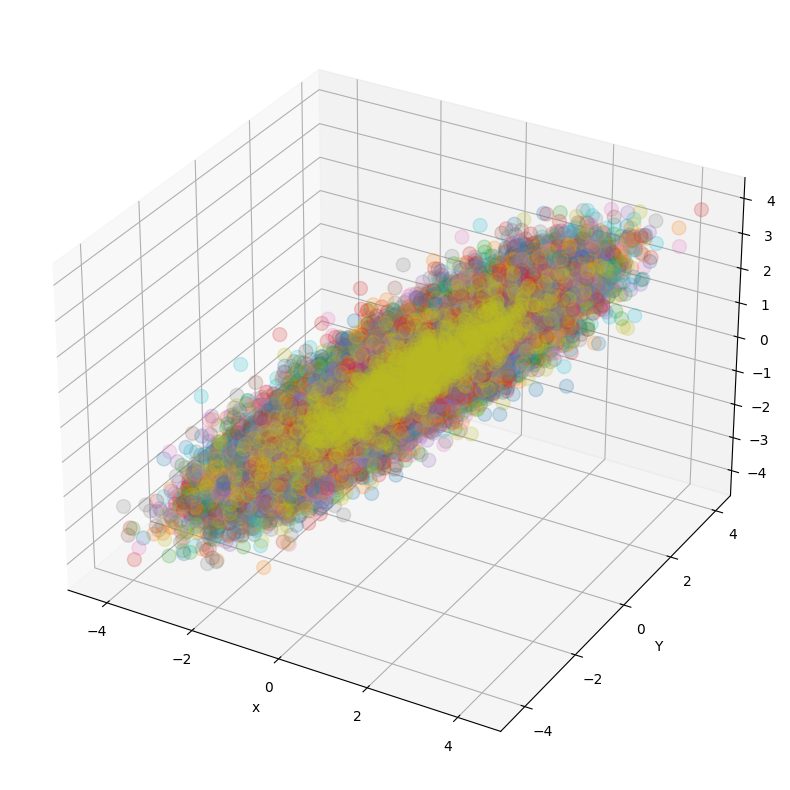

In [ ]:
fx = cat_arr.cpu().detach().numpy()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for data in fx:
    x = data[0]
    # print(data[0].shape)
    y = data[1]
    z = data[2]
    ax.scatter(x, y, z, s=100, cmap='rainbow', alpha=0.2)

ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('3')

plt.show()

[1,2,3,4,5] [11,12,13,14,15] [21,22,23,24,25]

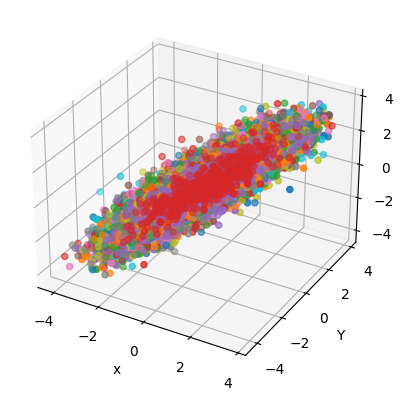

In [ ]:
fx = cat_arr[:,:,:500].cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', alpha = 0.2)

for data in fx:
    x = data[0]
    y = data[1]
    z = data[2]
    ax.scatter(x, y, z)

ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('3')

plt.show()

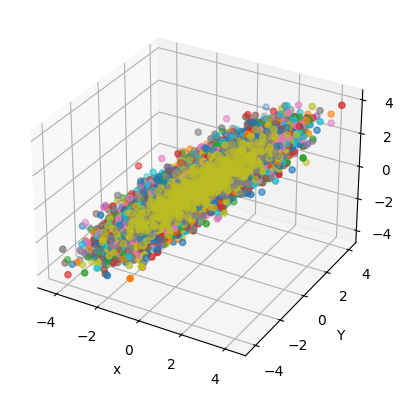

In [ ]:
fx = cat_arr[:,:,500:].cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', alpha=0.2)

for data in fx:
    x = data[0]
    y = data[1]
    z = data[2]
    ax.scatter(x, y, z)

ax.set_xlabel('x')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('3')

plt.show()

In [ ]:
import torch
import torch.nn as nn

batch_size = 3
feature_dim = 256
time_step = 16000

x = torch.rand(2206, 1, 50)

conv1d = nn.Conv1d(1, 1, kernel_size=10, stride=2)
conv1d_2 = nn.Conv1d(1,1, kernel_size=5, stride=3)
li1 = nn.Linear(3, 35)
li2 = nn.Linear(35,50)
li3 = nn.Linear(21,50)

out = conv1d(x)
print(out.shape)
# out = conv1d_2(out)
# print(out.shape)


# out = li1(out)
# out = li2(out)
out = li3(out)

print('output_size:',out.shape)

torch.Size([2206, 1, 21])
output_size: torch.Size([2206, 1, 50])


In [ ]:
x = torch.rand(257, 500, 19)

conv1d = nn.Conv1d(500, 700, kernel_size=5, stride=3)
conv1d_2 = nn.Conv1d(700,700, kernel_size=3, stride=1)
li1 = nn.Linear(700,500)
li2 = nn.Linear(3,50)

out = conv1d(x)
out = conv1d_2(out)
out = li2(out)
out = li1(out.transpose(1,2)).transpose(1,2)

print('output_size:',out.shape)

output_size: torch.Size([257, 500, 50])


In [ ]:
import torch
import torch.nn as nn
x = torch.rand(257, 500, 19)

conv1d = nn.Conv1d(500, 50, kernel_size=5, stride=3)
conv1d_2 = nn.Conv1d(50,1, kernel_size=3, stride=1)
li1 = nn.Linear(3,30)
li2 = nn.Linear(30,19)

out = conv1d(x)
out = conv1d_2(out)
out = li1(out)
out = li2(out)

print('output_size:',out.shape)

output_size: torch.Size([257, 1, 19])


(11026, 50, 1)
(11026, 50, 1)
mae :  0.6918198447504701
mse :  0.6356785885031787
rmse :  0.797294543128936


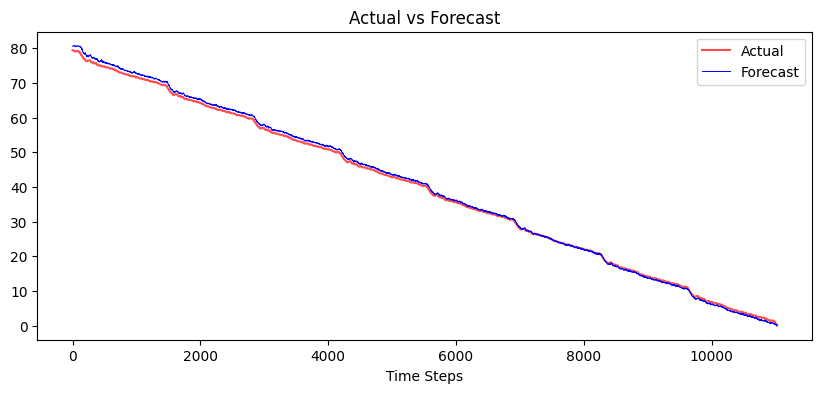

In [ ]:
eval_dataset = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=1)
# eval_dataset = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=1)
# eval_dataset = StrideDataset("DST_80.csv", 50, 20, 1919, stride=1)
# eval_dataset = StrideDataset("US06_80.csv", 50, 20, 1207, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False, drop_last=False)

# 
dataset_d = CustomDataset("FUDS_80.csv", 2586)
# dataset_d = CustomDataset("BJDST_80.csv", 1226)
# dataset_d = CustomDataset("DST_80.csv", 1919)
# dataset_d = CustomDataset("US06_80.csv", 1207)



predictions_zerosum = torch.zeros(69)
predictions_zerosum.shape
predictions_zerosum

model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)
cnt=0

with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        output = output.permute(1,0,2)
        
        cnt=cnt+1
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


# print(predictions.shape)
# print(dataset_d.y.shape)
# print(cnt)

predictions = torch.concat((predictions_zerosum, predictions),0)

predictions = predictions * 80.0

plt.figure(figsize=(10,4))
plt.plot(dataset_d.y[69:], color='red', alpha=0.7)
plt.plot(predictions[69:], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
# plt.xlim([2800,3000])
# plt.ylim([56.5,60.5])


from sklearn.metrics import mean_absolute_error, mean_squared_error

# print(dataset_d.y.shape)
# print(predictions.shape)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], predictions[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], predictions[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], predictions[69:10000])))




(11142, 50, 1)
(11142, 50, 1)
mae :  0.6992930028888509
mse :  0.6480814924264501
rmse :  0.8050350876989463


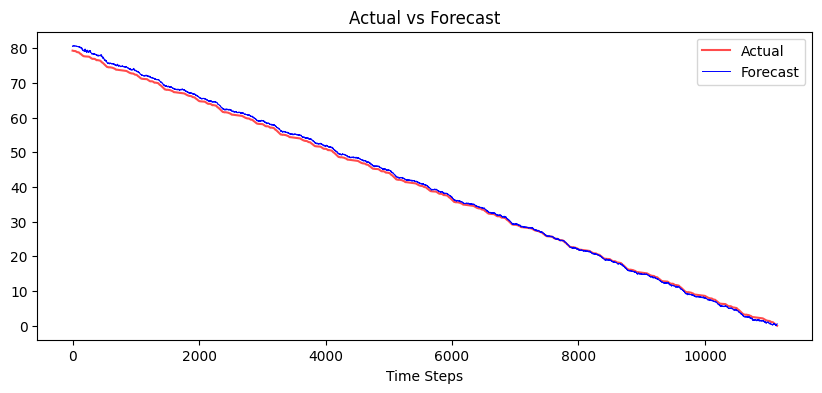

In [ ]:
# eval_dataset = StrideDataset("FUDS_80.csv", 50, 20, 2586, stride=1)
eval_dataset = StrideDataset("BJDST_80.csv", 50, 20, 1226, stride=1)
# eval_dataset = StrideDataset("DST_80.csv", 50, 20, 1919, stride=1)
# eval_dataset = StrideDataset("US06_80.csv", 50, 20, 1207, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=256, shuffle=False, drop_last=False)

# 
# dataset_d = CustomDataset("FUDS_80.csv", 2586)
dataset_d = CustomDataset("BJDST_80.csv", 1226)
# dataset_d = CustomDataset("DST_80.csv", 1919)
# dataset_d = CustomDataset("US06_80.csv", 1207)


predictions_zerosum = torch.zeros(69)
predictions_zerosum.shape
predictions_zerosum

model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)
cnt=0

with torch.no_grad():
    for (inputs_v, inputs_c, dec_inputs, outputs) in eval_dataloader:
        src_mask_v = model.generate_square_subsequent_mask(inputs_v.shape[1]).to(device)
        src_mask_c = model.generate_square_subsequent_mask(inputs_c.shape[1]).to(device)
        tgt_mask = model.generate_square_subsequent_mask(dec_inputs.shape[1]).to(device)
        
        output = model(inputs_v.float().to(device), inputs_c.float().to(device), dec_inputs.float().to(device), src_mask_v, src_mask_c, tgt_mask)
        output = output.permute(1,0,2)
        
        cnt=cnt+1
        predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0) # view(-1) => 1차원으로 바꾼다 생각
        actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


# print(predictions.shape)
# print(dataset_d.y.shape)
# print(cnt)

predictions = torch.concat((predictions_zerosum, predictions),0)

predictions = predictions * 80.0

plt.figure(figsize=(10,4))
plt.plot(dataset_d.y[69:], color='red', alpha=0.7)
plt.plot(predictions[69:], color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
# plt.xlim([2800,3000])
# plt.ylim([56.5,60.5])


from sklearn.metrics import mean_absolute_error, mean_squared_error

# print(dataset_d.y.shape)
# print(predictions.shape)

print("mae : ", mean_absolute_error(dataset_d.y[69:10000], predictions[69:10000]))
print("mse : ", mean_squared_error(dataset_d.y[69:10000], predictions[69:10000]))
print("rmse : ", np.sqrt(mean_squared_error(dataset_d.y[69:10000], predictions[69:10000])))


